In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import matplotlib.pyplot as plt

from hw_utils import (bootstrap, cluster, non_pivotal_conf_interval,
                      pivotal_conf_interval, print_clusters_info,
                      quantification_scalar, quantification_set)

sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(12, 6)})

# Предобработка данных

In [4]:
imdb_data = pd.read_csv('imdb.csv')

imdb_data = imdb_data.drop(columns=['Rank', 'Description', 'Director', 'Actors'])
imdb_data = imdb_data.dropna()
imdb_data = imdb_data[imdb_data['Year'] < 2014]
imdb_data = imdb_data.reset_index(drop=True)
imdb_data = imdb_data.rename(columns={'Runtime (Minutes)': 'Runtime', 'Revenue (Millions)': 'Revenue'})

imdb_data

,Title,Genre,Year,Runtime,Rating,Votes,Revenue,Metascore
0,Prometheus,"Adventure,Mystery,Sci-Fi",2012,124,7.0,485820,126.46,65.0
1,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",2011,136,6.7,395025,241.06,45.0
2,The Dark Knight,"Action,Crime,Drama",2008,152,9.0,1791916,533.32,82.0
3,The Prestige,"Drama,Mystery,Sci-Fi",2006,130,8.5,913152,53.08,66.0
4,Pirates of the Caribbean: At World's End,"Action,Adventure,Fantasy",2007,169,7.1,498821,309.40,50.0
...,...,...,...,...,...,...,...,...
433,Taare Zameen Par,"Drama,Family,Music",2007,165,8.5,102697,1.20,42.0
434,Resident Evil: Afterlife,"Action,Adventure,Horror",2010,97,5.9,140900,60.13,37.0
435,Project X,Comedy,2012,88,6.7,164088,54.72,48.0
436,Hostel: Part II,Horror,2007,94,5.5,73152,17.54,46.0


In [5]:
imdb_data = quantification_scalar(imdb_data, "Year")
imdb_data = quantification_set(imdb_data, "Genre")

imdb_data

/Users/Konstantin/mmda_imdb/hw_utils.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_frame[label][i] = 1 if value in data_frame[column_label][i] else 0


,Title,Runtime,Rating,Votes,Revenue,Metascore,Year_2006,Year_2007,Year_2008,Year_2009,...,Genre_Romance,Genre_Comedy,Genre_Horror,Genre_Sport,Genre_Western,Genre_Thriller,Genre_Sci-Fi,Genre_Adventure,Genre_Fantasy,Genre_History
0,Prometheus,124,7.0,485820,126.46,65.0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Pirates of the Caribbean: On Stranger Tides,136,6.7,395025,241.06,45.0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,The Dark Knight,152,9.0,1791916,533.32,82.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,The Prestige,130,8.5,913152,53.08,66.0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,Pirates of the Caribbean: At World's End,169,7.1,498821,309.40,50.0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
433,Taare Zameen Par,165,8.5,102697,1.20,42.0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
434,Resident Evil: Afterlife,97,5.9,140900,60.13,37.0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
435,Project X,88,6.7,164088,54.72,48.0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
436,Hostel: Part II,94,5.5,73152,17.54,46.0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0


# HW 2
Код ниже разобъет наши данные на `n_clusters` кластеров, используя колонки `columns`. `imdb_data_clustered` - датафрейм со всеми данными из `imdb_data` и дополнительной колонкой `Cluster` содержащей индекс кластера, к которому относится данная строка. Индекс - это целое число от `0` до `imdb_data_clustered - 1`.

In [6]:
columns = ['Runtime', 'Rating', 'Votes', 'Revenue', 'Metascore']
n_clusters = 9

imdb_data_clustered, inertia = cluster(imdb_data, clusters_number=n_clusters, clustering_columns_labels=columns)
print(f'Inertia: {inertia}')
print()
print_clusters_info(imdb_data_clustered, item_id_label='Title', clustering_columns_labels=columns)

Inertia: 15.946498227628387

Cluster № 1
------------------------------


,,Revenue,Metascore,Votes,Runtime,Rating
0,Within cluster mean,54.702361,70.666667,221542.305556,102.652778,7.225000
1,Grand mean,98.444269,60.408676,261530.098174,116.251142,6.924201
2,Difference,-43.741908,10.257991,-39987.792618,-13.598364,0.300799
3,"Difference, %",-0.444332,0.169810,-0.152899,-0.116974,0.043442


Items:
Scott Pilgrim vs. the World
Tropic Thunder
Drive
The Perks of Being a Wallflower
The Intouchables
Kynodontas
The Conjuring
Pitch Perfect
The Devil Wears Prada
The Cabin in the Woods
Midnight in Paris
This Is the End
Zombieland
Wanted
Magic Mike
Shame
Hanna
The imposible
Coraline
Revolutionary Road
Salt
The Other Guys
Forgetting Sarah Marshall
Moonrise Kingdom
Stake Land
Cloverfield
Under the Skin
Super 8
(500) Days of Summer
Easy A
Limitless
Enchanted
Little Miss Sunshine
Sunshine
Moon
Megamind
Don Jon
Source Code
Eastern Promises
Pineapple Express
Gone Baby Gone
We Need to Talk About Kevin
Hunger
Happy Feet
Friends with Benefits
The Illusionist
Fracture
In Bruges
The World's End
Seven Psychopaths
1408
The Spectacular Now
Fantastic Mr. Fox
127 Hours
Rocky Balboa
The Princess and the Frog
Unstoppable
Begin Again
Vicky Cristina Barcelona
Locke
28 Weeks Later
Blue Jasmine
Rio
50/50
The Fall
Slither
Contagion
Bridge to Terabithia
Coherence
Precious
Talladega Nights: The Ballad of Ri

,,Revenue,Votes,Metascore,Rating,Runtime
0,Within cluster mean,246.272667,455179.533333,74.166667,7.603333,106.000000
1,Grand mean,98.444269,261530.098174,60.408676,6.924201,116.251142
2,Difference,147.828397,193649.435160,13.757991,0.679132,-10.251142
3,"Difference, %",1.501646,0.740448,0.227749,0.098081,-0.088181


Items:
Harry Potter and the Deathly Hallows: Part 2
Star Trek
Frozen
Iron Man
Cars
The Hangover
Rise of the Planet of the Apes
Black Swan
21 Jump Street
Despicable Me
Tangled
Monsters University
The Bourne Ultimatum
World War Z
Ratatouille
I Am Legend
Up
Gravity
Alice in Wonderland
Wreck-It Ralph
Juno
Brave
X-Men: The Last Stand
The Pursuit of Happyness
Toy Story 3
Ted
True Grit
How to Train Your Dragon
Despicable Me 2
Kung Fu Panda

Cluster № 3
------------------------------


,,Revenue,Votes,Runtime,Rating,Metascore
0,Within cluster mean,270.855429,452501.057143,140.942857,7.134286,60.685714
1,Grand mean,98.444269,261530.098174,116.251142,6.924201,60.408676
2,Difference,172.411159,190970.958969,24.691716,0.210085,0.277038
3,"Difference, %",1.751358,0.730206,0.212400,0.030341,0.004586


Items:
Pirates of the Caribbean: On Stranger Tides
Pirates of the Caribbean: At World's End
Pirates of the Caribbean: Dead Man's Chest
300
Furious 6
The Great Gatsby
Shutter Island
The Hunger Games
Captain America: The First Avenger
X: First Class
Transformers
Skyfall
The Hobbit: An Unexpected Journey
Iron Man Three
Sherlock Holmes
Man of Steel
The Blind Side
Harry Potter and the Order of the Phoenix
Fast Five
Spider-Man 3
Star Trek Into Darkness
The Amazing Spider-Man
Harry Potter and the Deathly Hallows: Part 1
Mission: Impossible - Ghost Protocol
Iron Man 2
2012
Harry Potter and the Half-Blood Prince
The Hobbit: The Desolation of Smaug
Transformers: Dark of the Moon
The Hunger Games: Catching Fire
Transformers: Revenge of the Fallen
The Karate Kid
The Da Vinci Code
Indiana Jones and the Kingdom of the Crystal Skull
Superman Returns

Cluster № 4
------------------------------


,,Revenue,Votes,Runtime,Metascore,Rating
0,Within cluster mean,40.929677,134955.532258,97.854839,52.290323,6.469355
1,Grand mean,98.444269,261530.098174,116.251142,60.408676,6.924201
2,Difference,-57.514592,-126574.565915,-18.396303,-8.118353,-0.454846
3,"Difference, %",-0.584235,-0.483977,-0.158246,-0.134391,-0.065689


Items:
Diary of a Wimpy Kid
Spring Breakers
Predators
The House Bunny
She's Out of My League
The Fast and the Furious: Tokyo Drift
Step Up
Step Brothers
Taken
Kick-Ass 2
Dredd
Carrie
Enemy
The Boy in the Striped Pyjamas
Half of a Yellow Sun
Trust
Idiocracy
The Expendables
Evil Dead
All Good Things
She's the Man
Horrible Bosses
Underworld Awakening
Antichrist
Insidious
The First Time
Faster
Closed Circuit
The Strangers
Paul
Oculus
The Purge
The Fountain
Hancock
Zack and Miri Make a Porno
Man on a Ledge
No Strings Attached
Mama
Diary of a Wimpy Kid: Dog Days
The Dictator
The Hills Have Eyes
Diary of a Wimpy Kid: Rodrick Rules
One Day
Warm Bodies
Piranha 3D
Rambo
Snakes on a Plane
What If
The Expendables 2
Centurion
17 Again
Super
The Midnight Meat Train
The Kings of Summer
Death Race
Trance
Texas Chainsaw 3D
Final Destination 5
Underworld: Rise of the Lycans
Project X
Hostel: Part II
Step Up 2: The Streets

Cluster № 5
------------------------------


,,Votes,Runtime,Revenue,Metascore,Rating
0,Within cluster mean,369785.093750,155.000000,72.790000,70.750000,7.815625
1,Grand mean,261530.098174,116.251142,98.444269,60.408676,6.924201
2,Difference,108254.995576,38.748858,-25.654269,10.341324,0.891424
3,"Difference, %",0.413929,0.333320,-0.260597,0.171189,0.128740


Items:
Inglourious Basterds
The Wolf of Wall Street
Prisoners
The Help
The Departed
The Place Beyond the Pines
Django Unchained
Watchmen
Casino Royale
Warrior
Into the Wild
The Girl with the Dragon Tattoo
Apocalypto
Les Misérables
Cloud Atlas
Zodiac
There Will Be Blood
La vie d'Adèle
Lincoln
Zero Dark Thirty
The Curious Case of Benjamin Button
3 Idiots
American Gangster
Män som hatar kvinnor
The Assassination of Jesse James by the Coward Robert Ford
Public Enemies
Blood Diamond
Australia
Changeling
Babel
Perfume: The Story of a Murderer
Taare Zameen Par

Cluster № 6
------------------------------


,,Votes,Metascore,Revenue,Rating,Runtime
0,Within cluster mean,115133.962264,34.150943,62.584340,5.569811,105.528302
1,Grand mean,261530.098174,60.408676,98.444269,6.924201,116.251142
2,Difference,-146396.135909,-26.257732,-35.859930,-1.354390,-10.722840
3,"Difference, %",-0.559768,-0.434668,-0.364266,-0.195602,-0.092239


Items:
Aliens vs Predator - Requiem
The Host
Sucker Punch
The Three Musketeers
Jennifer's Body
Grown Ups 2
Couples Retreat
The Babysitters
Pandorum
I Am Number Four
Just Go with It
Safe Haven
Movie 43
The Happening
The Counselor
The Green Inferno
The Break-Up
Clash of the Titans
What to Expect When You're Expecting
Ghost Rider
Adoration
Never Back Down
Friday the 13th
Green Lantern
The Mortal Instruments: City of Bones
Jumper
Resident Evil: Retribution
Grown Ups
The Mummy: Tomb of the Dragon Emperor
Percy Jackson: Sea of Monsters
This Means War
Lady in the Water
The Family
G.I. Joe: The Rise of Cobra
Disaster Movie
Fool's Gold
Dragonball Evolution
Red Dawn
Life as We Know It
G.I. Joe: Retaliation
Wrath of the Titans
The Lucky One
The Ugly Truth
Bride Wars
The Twilight Saga: Breaking Dawn - Part 1
The Human Centipede (First Sequence)
What's Your Number?
After Earth
Sex and the City 2
Legion
I Spit on Your Grave
Your Highness
Resident Evil: Afterlife

Cluster № 7
------------------------

,,Votes,Revenue,Metascore,Rating,Runtime
0,Within cluster mean,201049.453608,84.014948,52.556701,6.708247,119.608247
1,Grand mean,261530.098174,98.444269,60.408676,6.924201,116.251142
2,Difference,-60480.644565,-14.429321,-7.851975,-0.215953,3.357106
3,"Difference, %",-0.231257,-0.146573,-0.129981,-0.031188,0.028878


Items:
Prometheus
Thor
Mamma Mia!
Pacific Rim
Twilight
Thor: The Dark World
We're the Millers
Percy Jackson & the Olympians: The Lightning Thief
Battleship
Nymphomaniac: Vol. I
X-Men Origins: Wolverine
Oblivion
Now You See Me
Lone Survivor
RocknRolla
In Time
Fast & Furious
White House Down
About Time
The Twilight Saga: Breaking Dawn - Part 2
Robin Hood
The Wolverine
John Carter
The Incredible Hulk
Oz the Great and Powerful
Olympus Has Fallen
The Proposal
Sherlock Holmes: A Game of Shadows
Marie Antoinette
The Book of Eli
Men in Black 3
Law Abiding Citizen
Savages
Shooter
The Bourne Legacy
A Good Year
Jack Reacher
Sinister
Snow White and the Huntsman
Tron
Immortals
Gangster Squad
Beautiful Creatures
The Lovely Bones
The Secret Life of Walter Mitty
Total Recall
Love & Other Drugs
Lawless
American Reunion
The Heat
Anna Karenina
Pain & Gain
The Mist
Escape Plan
Seven Pounds
RED
The Heartbreak Kid
Nymphomaniac: Vol. II
Dark Shadows
The A-Team
The Internship
Body of Lies
August Rush
Eagle Ey

,,Revenue,Metascore,Votes,Rating,Runtime
0,Within cluster mean,63.860577,81.192308,321591.711538,7.605769,123.519231
1,Grand mean,98.444269,60.408676,261530.098174,6.924201,116.251142
2,Difference,-34.583692,20.783632,60061.613365,0.681568,7.268089
3,"Difference, %",-0.351302,0.344050,0.229655,0.098433,0.062521


Items:
The Prestige
12 Years a Slave
No Country for Old Men
Superbad
Crazy, Stupid, Love.
Hot Fuzz
Her
Bridesmaids
Kick-Ass
Pan's Labyrinth
Children of Men
Snowpiercer
The Social Network
Dallas Buyers Club
Rush
Silver Linings Playbook
Looper
Stardust
American Hustle
Slumdog Millionaire
Blue Valentine
Jagten
The Town
District 9
Argo
The Lives of Others
Hairspray
The Ghost Writer
Moneyball
Let Me In
Hellboy II: The Golden Army
The Host
Knocked Up
Sweeney Todd: The Demon Barber of Fleet Street
The Hurt Locker
The King's Speech
Tinker Tailor Soldier Spy
Life of Pi
Live Free or Die Hard
Incendies
Hugo
El secreto de sus ojos
The Fighter
Captain Phillips
Rescue Dawn
Inside Man
Jane Eyre
Melancholia
Flight
The Tree of Life
The Descendants
The Skin I Live In

Cluster № 9
------------------------------


,,Revenue,Votes,Runtime,Metascore,Rating
0,Within cluster mean,531.562000,1.315836e+06,153.800000,77.200000,8.440000
1,Grand mean,98.444269,2.615301e+05,116.251142,60.408676,6.924201
2,Difference,433.117731,1.054306e+06,37.548858,16.791324,1.515799
3,"Difference, %",4.399624,4.031300e+00,0.322998,0.277962,0.218913


Items:
The Dark Knight
The Avengers
Inception
Avatar
The Dark Knight Rises



# HW 3

#### 3.1 Compare one of the features between two clusters with using bootstrap
``Metascore`` is being compared between clusters #1 and #3. 

In [7]:
metascore_cluster_one = imdb_data_clustered['Metascore'][imdb_data_clustered['Cluster'] == 0].to_numpy()
metascore_cluster_three = imdb_data_clustered['Metascore'][imdb_data_clustered['Cluster'] == 2].to_numpy()

/Users/Konstantin/opt/anaconda3/envs/coreml/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


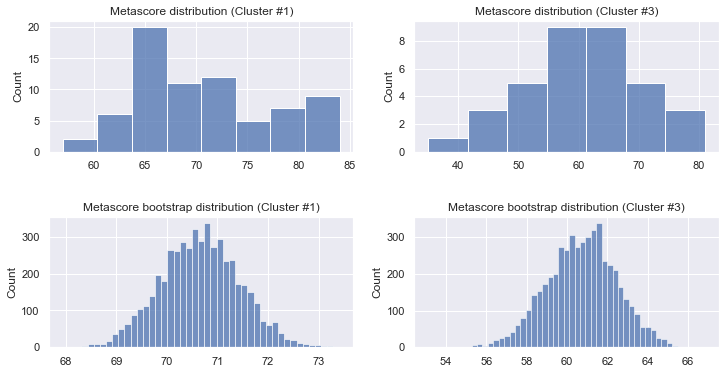

In [8]:
# Metascores' feature distribution (for 1st and 3rd clusters) w/wo bootstrap
metascore_one_stats = bootstrap(metascore_cluster_one, pivotal=False, non_pivotal=False)
metascore_three_stats = bootstrap(metascore_cluster_three, pivotal=False, non_pivotal=False)

fig, ax = plt.subplots(2,2)
sns.histplot(metascore_cluster_one, ax=ax[0, 0])
sns.histplot(metascore_cluster_three, ax=ax[0, 1])
sns.histplot(metascore_one_stats['mean_trials'], ax=ax[1, 0])
sns.histplot(metascore_three_stats['mean_trials'], ax=ax[1, 1])
ax[0, 0].set_title('Metascore distribution (Cluster #1)')
ax[0, 1].set_title('Metascore distribution (Cluster #3)')
ax[1, 0].set_title('Metascore bootstrap distribution (Cluster #1)')
ax[1, 1].set_title('Metascore bootstrap distribution (Cluster #3)')
fig.subplots_adjust(hspace = 0.5)
fig.show()

Feature ``metascore`` is being compared between clusters #1 and #3. Here, the main hypothesis $H_0: \mu_1 = \mu_2$ vs alternative $H_1: \mu_1 \ne \mu_2$. The algorithm is as it was in the lecture: bootstrap distributions of K trials in cluster #1 and #3 will be computed. Afterwards, confidense intervals for differences of means will be computed. If 0 is in interval, then $H_0$ is accepted, otherwise, rejected.

In [29]:
# Checking if means of distributions of feature Metascore from clusters #1 and #3 are equal
difference = metascore_one_stats['mean_trials'] - metascore_three_stats['mean_trials']

piv_conf_int = pivotal_conf_interval(difference)
non_piv_conf_int = non_pivotal_conf_interval(difference)

print("Pivotal confidense interval for difference of means is {} - {}".format(*piv_conf_int))
print("Non-pivotal confidense interval for difference of means is {} - {}".format(*non_piv_conf_int))

Pivotal confidense interval for difference of means is 6.228172385519969 - 13.677760789083209
Non-pivotal confidense interval for difference of means is 6.344047619047615 - 13.722222222222229


As it could be seen, intervals from both tests don't include 0 value $\implies$ means of distributions of feature ``metascore`` for cluster #1 and #3 aren't equal.

#### 3.2 Take a feature, find the 95% confidence interval for its grand mean by using bootstrap
95% confidence interval for feature ``Revenue`` will be computed

In [13]:
revenue = imdb_data_clustered['Revenue'].to_numpy()
stats, conf_piv, conf_non_piv = bootstrap(revenue)

In [17]:
mean = stats['mean']
std = stats['std']

/Users/Konstantin/opt/anaconda3/envs/coreml/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


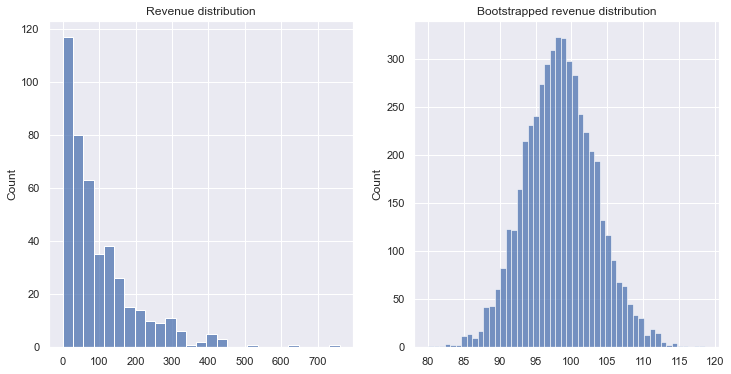

In [26]:
fig, ax = plt.subplots(1,2) 
sns.histplot(revenue, ax=ax[0])
sns.histplot(stats['mean_trials'], ax=ax[1])
ax[0].set_title('Revenue distribution')
ax[1].set_title('Bootstrapped revenue distribution')
fig.show()

In [20]:
print("Pivotal confidence interval for global mean of feature \"Revenue\" is {} - {}".format(*conf_piv))
print("Non-pivotal confidence interval for global mean of feature \"Revenue\" is {} - {}".format(*conf_non_piv))

Pivotal confidence interval for global mean of feature "Metascore" is 88.6590064870523 - 108.16533902892937
Non-pivotal confidence interval for global mean of feature "Metascore" is 88.86422374429222 - 108.58883561643826


Pivotal and non-pivotal confidence instervals for feature ``Revenue``are pretty much the same. 

#### 3.3 Take a cluster, and compare the grand mean with the within-cluster mean for the feature by using bootstrap
Here, mean and grand mean of feature ``Rating`` for cluster #5 will be compared. 

In [27]:
rating_cluster_five = imdb_data_clustered['Rating'][imdb_data_clustered['Cluster'] == 4].to_numpy()
rating = imdb_data_clustered['Rating'].to_numpy()

In [28]:
rating_cluster_stats = bootstrap(rating_cluster_five, pivotal=False, non_pivotal=False)
rating_global_stats = bootstrap(rating, pivotal=False, non_pivotal=False)

In [30]:
difference = rating_cluster_stats['mean_trials'] - rating_global_stats['mean_trials']

piv_conf_int = pivotal_conf_interval(difference)
non_piv_conf_int = non_pivotal_conf_interval(difference)

print("Pivotal confidense interval for difference of means is {} - {}".format(*piv_conf_int))
print("Non-pivotal confidense interval for difference of means is {} - {}".format(*non_piv_conf_int))

Pivotal confidense interval for difference of means is 0.7197586329569092 - 1.0629745862211775
Non-pivotal confidense interval for difference of means is 0.7125142694064044 - 1.059061073059362


As in 3.1 intervals from both tests don't include 0 value $\implies$ means of distributions are not equal, but quite close to each other. 